In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/final_nlp/"

In [ ]:
! cp  {PROJECT_PATH}"datagen.py" ./
! cp {PROJECT_PATH}"dataaug.py" ./

In [ ]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Modelo CNN con generador, embedings de smiles y data-augmentation

In [ ]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [ ]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [ ]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [ ]:
df = pd.read_csv(PROJECT_PATH + 'data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [ ]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [ ]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [ ]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [ ]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

c1(=O)n(-c2cccc(OCc3ccccc3)c2)nc(OCC)o1
C(Oc1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1)C
c1c(OCc2ccccc2)cccc1-n1c(=O)oc(OCC)n1
O(CC)c1nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
c1cccc(COc2cc(-n3nc(OCC)oc3=O)ccc2)c1
C(C)Oc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
c1c(COc2cccc(-n3nc(OCC)oc3=O)c2)cccc1
c1ccccc1COc1cccc(-n2c(=O)oc(OCC)n2)c1
c1cccc(COc2cc(-n3nc(OCC)oc3=O)ccc2)c1
c1(=O)n(-c2cccc(OCc3ccccc3)c2)nc(OCC)o1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [ ]:
from datagen import DataGenerator

In [ ]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [ ]:
len(dgen) * dgen.batch_size

5664

In [ ]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train), len(y_train), len(X_test)

(4530, 4530, 1133)

In [ ]:
X_train

array(['COc1ccc(C(F)(F)F)c[n+]1C.F[B-](F)(F)F',
       '[Cl-].[Cl-].c1cc[n+](COC[n+]2ccccc2)cc1',
       'CCOC(=O)C1=C(C)Oc2nc3c(c(N)c2[C@H]1c1ccccc1)CCCC3', ...,
       'O=[N+]([O-])c1ccccc1-c1nnc(Nc2ncccn2)o1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [ ]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=64, data_augmentation=True)
# A la data de validación/test no se le realiza data augmentation porque necesitamos trabajar con datos reales
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=64, data_augmentation=False)

In [ ]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [ ]:
X_b.shape

(45, 227)

# Network Model(s)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [ ]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Definición de modelos

Pruebo con distintas arquitecturas. Para no alargar innecesariamente el tiempo de entrenamiento, implemento los siguientes callbacks:
- Early Stopping
- Reduce LR on Plateau

### Arquitectura A

Con Max Pooling en función del tamaño de las secuencias y 3 capas convolucionales por filtro. 

Las primeras pruebas daban señales de overfitting (R2 en entrenamiento mayor a R2 en validación), por lo que pruebo con Batch Normalization y/o Dropout

In [ ]:
# Implementar modelo de TextCNN
def text_cnn_1d_A(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(vocab_size + 1, embedding_size)(input_x)
    pooled_outputs = []
    max_pool_div = 4
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)

        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)

        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv)
        pooled_outputs.append(max_p)

    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = Dense(128, activation='relu')(dense)
    dense = Dense(128, activation='relu')(dense)
    dense = Dropout(0.8)(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

### Arquitectura B

Con MaxPool fijado en 100.

In [ ]:
# Implementar modelo de TextCNN
def text_cnn_1d_B(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(vocab_size + 1, embedding_size)(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = MaxPool1D(100)(conv)
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = Dense(256, activation='relu')(dense)
    dense = Dense(128, activation='linear')(dense)
    dense = Dense(64, activation='linear')(dense)
    dense = BatchNormalization()(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

### Arquitectura C
Con GlobalMaxPooling, sin capa Flatten

In [ ]:
# Implementar modelo de TextCNN
def text_cnn_1d_C(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(vocab_size + 1, embedding_size)(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = L.GlobalMaxPooling1D()(conv)
        pooled_outputs.append(max_p)

        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = L.GlobalMaxPooling1D()(conv)
        pooled_outputs.append(max_p)

        conv = Conv1D(num_filters, filter_size, padding='same', activation='relu')(embedding)
        max_p = L.GlobalMaxPooling1D()(conv)
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = Dense(256, activation='relu')(dense)
    dense = Dense(128, activation='linear')(dense)
    dense = Dense(64, activation='linear')(dense)
    dense = L.Dense(1)(dense) # Salida
    model = tf.keras.models.Model(input_x, dense)
    return model

## Callbacks

In [ ]:
def get_callbacks():

  early_stopping = EarlyStopping(
      monitor = 'val_loss',
      min_delta = 0.01,
      patience = 15,
      verbose = 1,
      restore_best_weights = True
  )

  reduce_lr = ReduceLROnPlateau(
      monitor = 'val_loss',
      factor = 0.05,
      patience = 10,
      verbose = 1,
      min_delta = 0.01,
      cooldown = 0,
      min_lr = 1e-8

  )

  checkpoint = ModelCheckpoint(
      filepath = PROJECT_PATH + 'models/cnn/best_model_{epoch}', 
      monitor = 'val_R2',
      verbose = True,
      mode = 'max',
      save_best_only = True,
      save_format = 'h5'
  )

  return (early_stopping, reduce_lr)

In [ ]:
callbacks = get_callbacks()

## Evaluación

In [ ]:
def score_model(model):
  X_test_eval = []
  y_t_eval = []
  for X_t, y_t in dgen_test:
      X_test_eval = X_test_eval + [list(t) for t in X_t]
      y_t_eval = y_t_eval + list(y_t)
  X_test_eval = np.array(X_test_eval)
  y_test = np.array(y_t_eval)

  y_pred = model.predict(X_test_eval)
  
  r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
  return r2

## Entrenamiento

Genero una función que crea el modelo, lo compila, lo entrena, lo puntúa y lo guarda.

In [ ]:
def try_model(tipo, nombre, params):
    
    if tipo == 'A':
      model = text_cnn_1d_A(*params)
    elif tipo == 'B':
      model = text_cnn_1d_B(*params)
    elif tipo == 'C':
      model = text_cnn_1d_B(*params)
    
    print(model.summary())
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[R2])
    history = model.fit(dgen_train, epochs=100, validation_data = dgen_test, callbacks=callbacks)

    r2 = score_model(model)
    print(f"\n R2 val:{r2}")
    
    model.save('./models/cnn/' + nombre + '.h5')

    return model


In [ ]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
filter_sizes = (3, 4, 5)
num_filters = 128
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2

params = (max_sequence_len, vocab_size, embeddings_size, filter_sizes, num_filters)

### Modelo A

In [ ]:
nombre = 'A_emb128_3xtextcnn_conc_flat_2x128-relu_drop80'
_ = try_model('A', nombre, params)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d_36 (Conv1D)             (None, 227, 128)     49280       ['embedding_6[0][0]']            
                                                                                                  
 conv1d_37 (Conv1D)             (None, 227, 128)     49280       ['embedding_6[0][0]']            
                                                                                            

### Modelo B

In [ ]:
nombre = 'B_emb128_textcnn100_conc_flat_128x64x32-relu-lin-lin'
_ = try_model('B', nombre, params)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 227, 128)     49280       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 227, 128)     65664       ['embedding_2[0][0]']            
                                                                                            

### Modelo C

In [ ]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
filter_sizes = (3, 4, 5)
num_filters = 128
vocab_size = len(smiles_dict)
embeddings_size = 128 # 2

params = (max_sequence_len, vocab_size, embeddings_size, filter_sizes, num_filters)

In [ ]:
nombre = 'C_emb128_3xCNN_Conc-256x128x64_rel_lin_lin'
_ = try_model('C', nombre, params)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 227, 128)     5504        ['input_x[0][0]']                
                                                                                                  
 conv1d_48 (Conv1D)             (None, 227, 128)     49280       ['embedding_8[0][0]']            
                                                                                                  
 conv1d_49 (Conv1D)             (None, 227, 128)     65664       ['embedding_8[0][0]']            
                                                                                            

## Resumen de resultados

- Arquitectura A (EMB>3xCNN>CONCAT>FLATTEN>DENSAS):
  - Emb 128,  2 densas x 128(relu) = 0.717
  - Emb 128, 2 densas x 256 (relu) y BatchNorm entre capas= 0.722
  - Emb 128, 2 densas x 128 (relu) y Dropout 80 al final = 0.62

- Arquitectura B:
  - B_emb128_textcnn100_conc_flat_128x64x32-relu-lin-lin' = 0.70

- Arquitectura C:
  - C_emb128_3xCNN_Conc-128x64x32_rel_lin_lin = 0.70
  - C_emb64_3xCNN_Conc-256x128x64_rel_lin_lin = 0.679
  - C_emb128_3xCNN_Conc-128x64x32_rel_lin_lin = 0.707

# Load model (solo si se grabo el modelo)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
filename = '/content/models/cnn/A_emb128_3xtextcnn_conc_flat_2x256-relu-BN.h5'

In [ ]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [ ]:
  X_test_eval = []
  y_t_eval = []
  for X_t, y_t in dgen_test:
      X_test_eval = X_test_eval + [list(t) for t in X_t]
      y_t_eval = y_t_eval + list(y_t)
  X_test_eval = np.array(X_test_eval)
  y_test = np.array(y_t_eval)

  y_pred = model_loaded.predict(X_test_eval)

In [ ]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.7221700820437034

# Evaluación

<function matplotlib.pyplot.show(*args, **kw)>

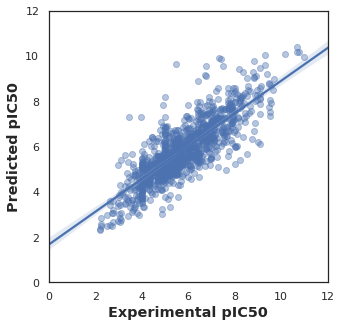

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show